# RL preliminaries

In [1]:

import gym, recogym
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
import os
from datetime import datetime
import pandas as pd
import pickle as pkl
pd.options.mode.chained_assignment = None 
# from inspect import getsource
from recogym.evaluate_agent_sale import verify_agents_sale, display_metrics, verify_agents_sale_extended 
from tqdm import tqdm

# env_1_sale_args is a dictionary of default parameters (i.e. number of products)
from recogym import env_1_sale_args, Configuration
from recogym.agents.sale_agent import train_agents, train_timeagents
from recogym.envs.utils_sale import format_avg_result, avg_result, format_avg_result_extended, avg_result_extended


# You can overwrite environment arguments here:
env_1_sale_args['random_seed'] = 0
env_1_sale_args['num_products'] = 10
env_1_sale_args['number_of_flips'] = 10 

num_products = env_1_sale_args['num_products']
print('Number of products =',num_products)
print('Number of flips =',env_1_sale_args['number_of_flips'])
nb_flips = env_1_sale_args['number_of_flips']

# You can overwrite environment arguments here:
env_1_sale_args['random_seed'] = 42
env_1_sale_args['mu_sale'] = False 

# env_1_sale_args['kappa'] = 0.5
print('Value of kappa =',env_1_sale_args['kappa'])

# Initialize the gym 
env = gym.make('reco-gym-sale-v1')
env.init_gym(env_1_sale_args)



Number of products = 10
Number of flips = 10
Value of kappa = 0.2


In [2]:
from recogym.agents.sale_agent_repeated import PseudoRewards, ShareViewsCountClicksFeatureProvider

# Define pseudo rewards
RewardTilde = PseudoRewards(clicks_only=False)

# Define user features
UserFeatures = ShareViewsCountClicksFeatureProvider(config = env.config )
UserFeatures.reset()

### Simulator rewards, online

In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch import optim
import itertools
import seaborn as sns
from recogym.agents.sale_agent_reinforce import Model, make_seed, REINFORCE 
# from recogym.agents.sale_agent_reinforce import Model, make_seed, REINFORCE,PseudoREINFORCE

learning_rate = 1e-3
seed = 1235
gamma = .5

config = {
    'learning_rate': learning_rate,
    'seed': env_1_sale_args['random_seed'],
    'gamma': gamma
}

print("Config : ",config)


Config :  {'learning_rate': 0.001, 'seed': 42, 'gamma': 0.5}


In [54]:
 def _compute_returns(self, rewards):
        num_rew = len(rewards)
        exponents = np.arange(num_rew)
        gammas = np.power(self.gamma, exponents)
        
        return rewards.dot(gammas)

In [92]:
class PseudoREINFORCE(REINFORCE):
        
    def __init__(self, config, env, user_features, pseudo_reward_provider):
        super().__init__(config, env, user_features)
        self.pseudo_reward_provider = pseudo_reward_provider
        # sanity checks
        self.reward_list = []
        self.pseudo_reward_list = []
        self.true_rewards = []
        self.loss_list = []
    
    def _compute_pseudo_returns(self, rewards, pseudo_rewards):
        num_rew = len(rewards)
        if num_rew > 0:
            future_rewards = []
            for i in range(num_rew-1):
                # the reward we consider are the reward at time i, and then the pseudo rewards
                R = np.array([rewards[i]]+pseudo_rewards[(i+1):])
                # the cumulative rewards at time i are discounted by gamma^{i},gamma^{i+1},gamma^{i+2}, etc.
                # however the discounts applied when computing the returns are : gamma^{0},gamma^{1},gamma^{2}, etc.
                R = (self.gamma**i)*R

                sum_future_rewards = self._compute_returns(R)
                try:
                    sum_future_rewards = np.sum(sum_future_rewards,dtype=np.float32)
                except:
                    print('Sum future rewards',sum_future_rewards)
                if sum_future_rewards < 0:
                    print('/!\ negative sum')
                    print('R=',R)
                    print('Sum future rewards',sum_future_rewards)
                    exponents = np.arange(len(R))
                    print("exponents",exponents)
                    gammas = np.power(self.gamma, exponents)
                    print('gammas',gammas)
                    print("returns",rewards.dot(gammas))
                future_rewards.append(sum_future_rewards)

            # append the last reward
            future_rewards.append((self.gamma**(num_rew-1))*rewards[num_rew-1])
            future_rewards = np.array(future_rewards)
            try:
                future_rewards = np.array(future_rewards,dtype=np.int32)
            except:
                print(future_rewards)
            return future_rewards
        else:
            return np.array(rewards)
        
    def optimize_model(self, n_trajectories):

        reward_trajectories = np.empty(n_trajectories)
        true_reward_trajectories = np.zeros(n_trajectories)
        loss = 0.
        
        for i in range(n_trajectories):
#             print('trajectory nb'+str(i))
#             print(datetime.now())
            traj_rewards = []  # rewards of the trajectory
            traj_pseudo_rewards = []  # pseudo rewards of the trajectory
#             traj_proba = 0.  # sum of log-probabilities of trajectory
            traj_proba = []  # list of log-probabilities of trajectory
        
            # Build trajectory
            done = False
            self.env.reset()
            # reset user features
            self.reset()
            obs_raw, _, done, reward = self.env.step(None)
            log = self.observation_to_log(obs_raw,reward)
            self.user_features.observe(log, memory=False)
            state = self.user_features.features()
            state = torch.from_numpy(state).float()
            
            while not done:
                action = self.model.select_action(state)  # can be cast to int for action idx
                # Get proba
                prob = self.model(state)[int(action)]
#                 traj_proba += torch.log(prob)
                traj_proba += [torch.log(prob)]
                
                obs_raw, reward, done, info = self.env.step(int(action))
                log = self.observation_to_log(obs_raw,reward)
                true_reward_trajectories[i] += sum(log['z']=='sale')
                if np.isnan(true_reward_trajectories[i]) or true_reward_trajectories[i]>1e100:
                    print('Nan encountered')
                self.user_features.observe(log, memory=False)
                state = self.user_features.features()
                state = torch.from_numpy(state).float()

                self.pseudo_reward_provider.pseudo_observe(log)
                pseudo_reward = self.pseudo_reward_provider.data_rewards
                immediate_sale = int(pseudo_reward['immediate_sale'])
                pseudo_reward = int(pseudo_reward['pseudo_y'])
                    
                # Store the new reward
                traj_rewards.append(reward)
                traj_pseudo_rewards.append(pseudo_reward)
            self.reward_list.append(traj_rewards)
            self.pseudo_reward_list.append(traj_pseudo_rewards)
            traj_pseudo_rewards = np.array(traj_pseudo_rewards)
#             traj_proba = torch.tensor(traj_proba)
            traj_proba = torch.tensor(traj_proba,requires_grad=True).double()
            reward_trajectories[i] = np.sum(traj_rewards)     
        
            # Get total reward
            if len(traj_rewards)>0:
                total_reward = torch.from_numpy(self._compute_pseudo_returns(traj_rewards, traj_pseudo_rewards)).double()            
                loss = loss + torch.dot(traj_proba,total_reward) / n_trajectories  # accumulate the negative criterion

            # reset user features construction and delete logs in memory
            self.reset()
            
        self.env.close()  # important
        
        loss = -loss
        self.loss_list.append(float(loss))
        
        # The following lines take care of the gradient descent step for the variable loss
        # that you need to compute.
        print("Loss:", loss.data.numpy())
        
        # Discard previous gradients
        self.optimizer.zero_grad()
        # Compute the gradient 
        loss.backward()
        # Do the gradient descent step
        self.optimizer.step()
        return reward_trajectories, true_reward_trajectories
    
    def train(self, n_trajectories, n_update):
        """Training method
prin
        Parameters
        ----------
        n_trajectories : int
            The number of trajectories used to approximate the expected gradient
        n_update : int
            The number of gradient updates
            
        """
        
        final_update = self.current_ep + n_update
        rewards = self.rewards  # initialize the reward record
        true_rewards = self.true_rewards
        
        for episode in range(self.current_ep, final_update):
            rew, true_rew = self.optimize_model(n_trajectories)
            rewards.append(rew)
            true_rewards.append(true_rew)
            print(f'\nEpisode {episode + 1}/{final_update}:')
            print('------ Attributed metrics')
            print(f'- Average attributed sales {round(rewards[-1].mean(), 2)} +/- {round(rewards[-1].std(), 2)}')
            print(f'- Total attributed sales {round(rewards[-1].sum(), 2)}')
            print(f'- Attributed CR {round(np.mean(np.array(rewards[-1])>0),4)}')

            print('------ True metrics')
            print(f'- Average true sales {round(true_rewards[-1].mean(), 2)} +/- {round(true_rewards[-1].std(), 2)}')
            print(f'- Total true sales {round(true_rewards[-1].sum(), 2)}')
            print(f'- True CR {round(np.mean(np.array(true_rewards[-1])>0),4)}')
        
    def plot_result_training(self):
        rewards = self.rewards  # initialize the reward record
        true_rewards = self.true_rewards
        # Plotting
        att_sales = pd.DataFrame((itertools.chain(*(itertools.product([i], rewards[i]) for i in range(len(rewards))))), 
                         columns=['Epoch', 'Sales'])
        att_sales['Metric'] = 'Attributed Sale'
        true_sales = pd.DataFrame((itertools.chain(*(itertools.product([i], true_rewards[i]) for i in range(len(true_rewards))))), 
                                 columns=['Epoch', 'Sales'])
        true_sales['Metric'] = 'True Sale'
        sales = pd.concat([att_sales,true_sales])
        plt.figure()
        sns.lineplot(x="Epoch", y='Sales', data=sales, hue = 'Metric', ci='sd')
        None
        plt.figure()
        loss_evol = pd.DataFrame({'Epoch':range(len(self.loss_list)),'Loss': self.loss_list})
        sns.lineplot(x="Epoch", y='Loss', data=loss_evol, ci='sd')
        None


In [93]:
try:
    print(agent)
except:
    agent = PseudoREINFORCE(config,env,UserFeatures,RewardTilde)
agent = PseudoREINFORCE(config,env,UserFeatures,RewardTilde)

In [94]:
n_users = 500
n_updates_tot = 100
n_updates = 10

Loss: 0.0398209547996521

Episode 1/10:
------ Attributed metrics
- Average attributed sales 0.33 +/- 0.8
- Total attributed sales 167.0
- Attributed CR 0.21
------ True metrics
- Average true sales 1.66 +/- 2.37
- Total true sales 832.0
- True CR 0.536
Loss: 0.040709150314331054

Episode 2/10:
------ Attributed metrics
- Average attributed sales 0.3 +/- 0.74
- Total attributed sales 149.0
- Attributed CR 0.18
------ True metrics
- Average true sales 1.45 +/- 2.44
- Total true sales 727.0
- True CR 0.514
Loss: 0.03265983724594116

Episode 3/10:
------ Attributed metrics
- Average attributed sales 0.29 +/- 0.73
- Total attributed sales 144.0
- Attributed CR 0.19
------ True metrics
- Average true sales 1.55 +/- 2.63
- Total true sales 773.0
- True CR 0.474
Loss: 0.05918231630325318

Episode 4/10:
------ Attributed metrics
- Average attributed sales 0.35 +/- 0.89
- Total attributed sales 177.0
- Attributed CR 0.204
------ True metrics
- Average true sales 1.66 +/- 2.38
- Total true sales

Loss: 0.0040240373611450195

Episode 2/10:
------ Attributed metrics
- Average attributed sales 0.25 +/- 0.76
- Total attributed sales 126.0
- Attributed CR 0.148
------ True metrics
- Average true sales 1.44 +/- 2.22
- Total true sales 718.0
- True CR 0.52
Loss: 0.02382462453842163

Episode 3/10:
------ Attributed metrics
- Average attributed sales 0.34 +/- 0.84
- Total attributed sales 172.0
- Attributed CR 0.218
------ True metrics
- Average true sales 1.53 +/- 2.27
- Total true sales 767.0
- True CR 0.548
Loss: 0.02726387906074524

Episode 4/10:
------ Attributed metrics
- Average attributed sales 0.35 +/- 0.82
- Total attributed sales 173.0
- Attributed CR 0.22
------ True metrics
- Average true sales 1.53 +/- 2.54
- Total true sales 764.0
- True CR 0.526
Loss: 0.01353711748123169

Episode 5/10:
------ Attributed metrics
- Average attributed sales 0.27 +/- 0.73
- Total attributed sales 137.0
- Attributed CR 0.166
------ True metrics
- Average true sales 1.31 +/- 2.08
- Total true 

Loss: 0.00492872953414917

Episode 3/10:
------ Attributed metrics
- Average attributed sales 0.33 +/- 0.79
- Total attributed sales 166.0
- Attributed CR 0.198
------ True metrics
- Average true sales 1.56 +/- 2.56
- Total true sales 782.0
- True CR 0.496
Loss: 0.042050879001617435

Episode 4/10:
------ Attributed metrics
- Average attributed sales 0.27 +/- 0.74
- Total attributed sales 137.0
- Attributed CR 0.174
------ True metrics
- Average true sales 1.37 +/- 2.21
- Total true sales 684.0
- True CR 0.488
Loss: 0.023188573837280273

Episode 5/10:
------ Attributed metrics
- Average attributed sales 0.27 +/- 0.7
- Total attributed sales 136.0
- Attributed CR 0.172
------ True metrics
- Average true sales 1.47 +/- 2.21
- Total true sales 733.0
- True CR 0.528
Loss: 0.05258491182327271

Episode 6/10:
------ Attributed metrics
- Average attributed sales 0.37 +/- 0.8
- Total attributed sales 183.0
- Attributed CR 0.23
------ True metrics
- Average true sales 1.71 +/- 2.38
- Total true s

Loss: 0.003976951599121094

Episode 4/10:
------ Attributed metrics
- Average attributed sales 0.26 +/- 0.71
- Total attributed sales 132.0
- Attributed CR 0.164
------ True metrics
- Average true sales 1.37 +/- 2.18
- Total true sales 687.0
- True CR 0.474
Loss: 0.021182567596435546

Episode 5/10:
------ Attributed metrics
- Average attributed sales 0.35 +/- 0.86
- Total attributed sales 174.0
- Attributed CR 0.206
------ True metrics
- Average true sales 1.7 +/- 2.67
- Total true sales 849.0
- True CR 0.5
Loss: 0.03618185710906983

Episode 6/10:
------ Attributed metrics
- Average attributed sales 0.36 +/- 0.85
- Total attributed sales 179.0
- Attributed CR 0.208
------ True metrics
- Average true sales 1.63 +/- 2.54
- Total true sales 813.0
- True CR 0.516
Loss: 0.01374834966659546

Episode 7/10:
------ Attributed metrics
- Average attributed sales 0.38 +/- 0.93
- Total attributed sales 192.0
- Attributed CR 0.22
------ True metrics
- Average true sales 1.65 +/- 2.48
- Total true sa

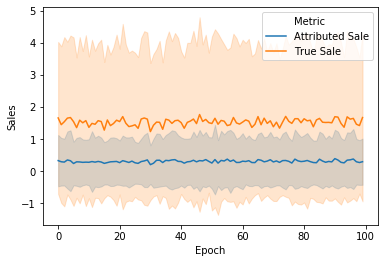

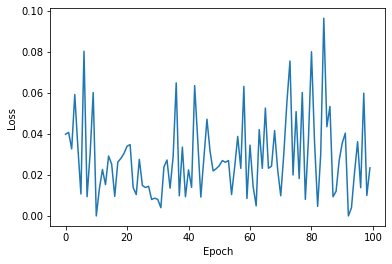

In [95]:
for i in range(int(n_updates_tot/n_updates)):
    t0=datetime.now()
    agent.train(n_trajectories=n_users, n_update=n_updates)
    print('Number of users : ',n_users)
    print('Number of updates : ',n_updates)

    # Save the model
    datetag = datetime.now().strftime("%d%m%Y-%H%M%S")
    PATH = f"data/RL/PseuRein_{n_users}_{n_updates}-{n_updates_tot}_{datetag}.pth"
    print(PATH)
    torch.save(agent.model.state_dict(), PATH)
    # agent.model.state_dict = torch.load(PATH)
    t1=datetime.now()
    print(t1-t0)
    
agent.plot_result_training()

In [ ]:
n_users = 500
n_updates_tot = 100
n_updates = 10

# n_users = 2
# n_updates = 2
# n_updates_tot = 4

In [ ]:
for i in range(int(n_updates_tot/n_updates)):
    t0=datetime.now()
    agent.train(n_trajectories=n_users, n_update=n_updates)
    print('Number of users : ',n_users)
    print('Number of updates : ',n_updates)

    # Save the model
    datetag = datetime.now().strftime("%d%m%Y-%H%M%S")
    PATH = f"data/RL/PseuRein_{n_users}_{n_updates}-{n_updates_tot}_{datetag}.pth"
    print(PATH)
    torch.save(agent.model.state_dict(), PATH)
    # agent.model.state_dict = torch.load(PATH)
    t1=datetime.now()
    print(t1-t0)

In [ ]:
config['n_users']=n_users
config['n_updates']=n_updates
config['n_updates_tot']=n_updates_tot
config['datetag']=datetag

In [ ]:
pkl.dump(agent.rewards,open(f'data/RL/PseuRein_att_{n_users}_{n_updates}-{n_updates_tot}_{datetag}.pkl','wb'))
pkl.dump(agent.true_rewards,open(f'data/RL/PseuRein_true_{n_users}_{n_updates}-{n_updates_tot}_{datetag}.pkl','wb'))
pkl.dump(agent.reward_list,open(f'data/RL/PseuRein_pseudor_{n_users}_{n_updates}-{n_updates_tot}_{datetag}.pkl','wb'))
pkl.dump(agent.pseudo_reward_list,open(f'data/RL/PseuRein_r_{n_users}_{n_updates}-{n_updates_tot}_{datetag}.pkl','wb'))
pkl.dump(agent,open(f'data/RL/PseuRein_ag_{n_users}_{n_updates}-{n_updates_tot}_{datetag}.pkl','wb'))
pkl.dump(config,open(f'data/RL/PseuRein_config_{n_users}_{n_updates}-{n_updates_tot}_{datetag}.pkl','wb'))

In [ ]:
agent.logged_observation

In [ ]:
ps_rew = list(itertools.chain(*agent.pseudo_reward_list))
print(np.unique(ps_rew))
rew = list(itertools.chain(*agent.reward_list))
print(np.unique(rew))

In [ ]:
plt.plot(rew)
plt.plot(ps_rew)

In [ ]:
print('avg rewards',np.mean(np.array(rew)))
print('avg baseline',np.mean(np.array(rew)-np.array(ps_rew)))

In [ ]:
reww = list(itertools.chain(*agent.rewards))
print(np.unique(reww))
true_reww = list(itertools.chain(*agent.true_rewards))
print(np.unique(true_reww)[-1])

In [ ]:
np.isnan(np.unique(true_reww)[-1])